# Packages import

In [ ]:
import Pkg
Pkg.add("Plots");
Pkg.add("BenchmarkTools");
Pkg.add("ForwardDiff");
Pkg.add("Plots");
Pkg.add("BenchmarkTools");
Pkg.add("SymPy");
Pkg.add("Roots");

# Namespaces

In [ ]:
using Plots;
using ForwardDiff
using SymPy, LinearAlgebra;
using BenchmarkTools;
using Roots;

# Dual numbers definition

In [ ]:
import Base: +, -, *, /
import Base: abs, sin, cos, tan, exp, sqrt, isless
import Base: convert, promote_rule
import Base: show,sum

struct Dual{T <:Number} <:Number
    v::T
    dv::T
end

-(x::Dual) = Dual(-x.v, -x.dv)
+(x::Dual, y::Dual) = Dual(x.v + y.v , x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v, x.dv - y.dv)
*(x::Dual, y::Dual) = Dual(x.v * y.v, x.dv * y.v + x.v * y.dv)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)

abs(x::Dual) = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual) = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual) = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual) = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
Base.exp(z::Dual) = (expval = exp(value(z)); Dual(expval, partials(z)*expval))
sqrt(x::Dual) = Dual(sqrt(x.v),0.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;
sum(x::Array{Dual{Float64},1}) = Dual(sum((p ->p.v).(x)), sum((p ->p.dv).(x)) )

convert(::Type{Dual{T}}, x::Dual) where T =
 Dual(convert(T, x.v), convert(T, x.dv))
convert(::Type{Dual{T}}, x::Number) where T =
 Dual(convert(T, x), zero(T))
promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} =
 Dual{promote_type(T,R)}

show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ϵ]\n");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;


function forwardDerivate(f, x :: Array{Float64,1})
    ϵ = Dual(0., 1.);
   return @. f(x + ϵ)
end

function forwardDerivate(f, xv :: Array{Float64,1}, yv :: Array{Float64,1})
    ϵ = Dual(0., 1.);
    
    z = f.(xv .+ ϵ, yv)
    dx = 5e-4partials.(z)
    z = f.(xv, yv .+ ϵ)
    dy = 5e-4partials.(z)
    zv = value.(z)  
    
    return dx, dy, zv
end

function forwardDerivateAllVector(f, x :: Array{Float64,1})
    output = []
    ϵ = Dual(0., 1.)

    for i in 1:1:length(x)
        list = convert(Array{Dual{Float64}}, deepcopy(x))
        list[i] = list[i] + ϵ
    
        append!(output, f(list)[i])
     end
    return output
end

J = function jacobian(f::Function, args::Vector{T}) where {T <:Number}
    jacobian_columns = Matrix{T}[]
    for i=1:length(args)
        x = Dual{T}[]
        for j=1:length(args)
            seed = (i == j)
            push!(x, seed ?
            Dual(args[j], one(args[j])) :
            Dual(args[j],zero(args[j])) )
        end
        column = partials.([f.(x)...])
        push!(jacobian_columns, column[:,:])
    end
    hcat(jacobian_columns...)
end

J = function jacobian(f::Function, xargs::Vector{T}, yargs::Vector{T}) where {T <:Number}
    xjacobian_columns = Matrix{T}[]
    yjacobian_columns = Matrix{T}[]
    @assert length(xargs) == length(yargs)
    for i=1:length(xargs)
        x = Dual{T}[]
        y = Dual{T}[]
        for j=1:length(xargs)
            seed = (i == j)
            push!(x, seed ?
            Dual(xargs[j], one(xargs[j])) :
            Dual(xargs[j],zero(xargs[j])) )
            push!(y, seed ?
            Dual(yargs[j], one(yargs[j])) :
            Dual(yargs[j],zero(yargs[j])) )
        end
        xcolumn = partials.([f.(x, yargs)...])
        ycolumn = partials.([f.(xargs, y)...])
        push!(xjacobian_columns, xcolumn[:,:])
        push!(yjacobian_columns, ycolumn[:,:])
    end
    hcat(xjacobian_columns...)
    hcat(yjacobian_columns...)
    xjacobian_columns, yjacobian_columns
end

# My Extra functions

In [73]:
function isTheSameValues(x::Array{Float64,1} , y::Array{Float64,1})
    #diffrenceArray ::Array{Float64,1} = x - y;
    if x == y
        println("Wyniki są takie same")
    else
        println("Wyniki są różne")
    end
end

function isTheSameValues(x::Array{Float64,2} , y::Array{Float64,2})
    #diffrenceArray ::Array{Float64,1} = x - y;
    if x == y
        println("Wyniki są takie same")
    else
        println("Wyniki są różne")
    end
end

function ReLUExactDiv(x)
    if(x <= 0) 
        return 0.0
        else return 1.0
        end
end

function errorValue(yValues::Array{Float64,1} , testValues::Array{Float64,1})
     error = (mean( abs.(yValues - testValues))) / ( mean(testValues))
    println("Wartość błędu wynosi: ");
    println(error);
    return error;
end

function ReLuLibJacobian()
   ReLu(x) = x > zero(x) ? x : zero(x)
   a =  [i for i in -1:0.25:0];
   b = [i for i in 0.25:0.25:1.25];
   aJac = ForwardDiff.jacobian(x ->ReLu(x), a);
   bJac = ForwardDiff.jacobian(x ->ReLu(x), b);
   
    return aJac, bJac
end

ReLuLibJacobian (generic function with 1 method)

# ReLu

## My value

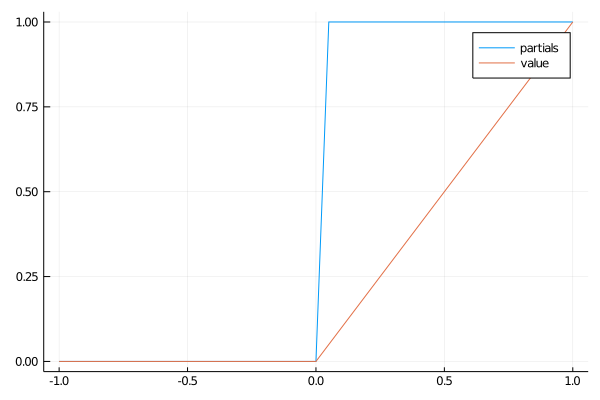

In [93]:
ReLu(x::Dual) = x > zero(x) ? x : zero(x)
x =collect(-1.0:0.05:1.0)
y = forwardDerivate(ReLu, x)

plot(x, (p->p.dv).(y), label = "partials")
plot!(x, (p->p.v).(y), label = "value")

In [81]:
@benchmark forwardDerivate(ReLu, x);

## Using lib

In [94]:
ReLu(x) = x > zero(x) ? x : zero(x)
    d = x -> ForwardDiff.derivative(ReLu, x);
    #plot(x, d.(x));

In [95]:
myValue = (p->p.dv).(y);
libValue = d.(x);

isTheSameValues(myValue, libValue)

Wyniki są takie same


## Exact value - comparation

In [97]:
y = @. ReLUExactDiv(x);;

a = forwardDerivate(ReLu, x);

errorValue(y, (p->p.dv).(a));

Wartość błędu wynosi: 
0.0


# Softmax

## My value 

In [ ]:
softmax(arg::Array{Dual{Float64}}) = exp.(arg) ./ sum(exp.(arg));
A = collect(-10.0:0.1:10.0)

output = forwardDerivateAllVector(softmax, A)
plot(A, (x->x.v).(output), label = "value")
display(plot!(A, (x->x.dv).(output), label = "derivative"))

In [ ]:
@benchmark forwardDerivateAllVector(softmax, A)

## Using lib

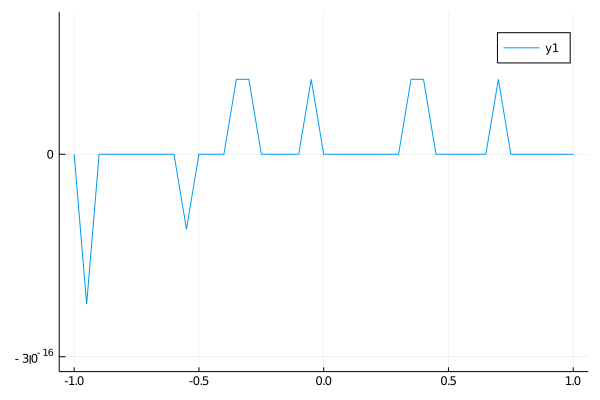

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\szymo\.julia\packages\PlotUtils\Rebxf\src\ticks.jl:283
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\szymo\.julia\packages\PlotUtils\Rebxf\src\ticks.jl:283
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\szymo\.julia\packages\PlotUtils\Rebxf\src\ticks.jl:283
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: ch

In [64]:
x = -1.0:0.05:+1.0
softmax(arg) = exp.(arg) ./ sum(exp.(arg));
d = x -> ForwardDiff.derivative(softmax, x)
 plot(x, d.(x))

# Sin

## My value 

In [ ]:
range =  collect(0:π/360:2*π);
sinus = forwardDerivate(sin, range);

plot(range, (x->x.v).(sinus), label = "sinus Dual.value")
plot!(range, (x->x.dv).(sinus), label = "sinus Dual.particle")

In [ ]:
@benchmark forwardDerivate(sin, range);

## Exact value - comparation

In [ ]:
x= symbols("x", real=true) # also integer, positive, negative...
f = sin(x)
dSin = diff(f,x);
dSin = convert(Function, dSin);
exactValue = dSin.(range);

myValue = (p->p.dv).(sinus);

isTheSameValues(myValue, exactValue)

# Cos

In [ ]:
range =  collect(0:π/360:2*π);
cosinus = forwardDerivate(cos, range);

plot(range, (x->x.v).(cosinus), label = "cosinus Dual.value")
plot!(range, (x->x.dv).(cosinus), label = "cosinus Dual.particle")

In [ ]:
@benchmark forwardDerivate(cos, range);

# Exact value - comparation

In [ ]:
x= symbols("x", real=true) # also integer, positive, negative...
f = cos(x);
dCos = diff(f,x);
dCos = convert(Function, dCos);
exactValue = dCos.(range);

myValue = (p->p.dv).(cosinus);

isTheSameValues(myValue, exactValue)


# Tan

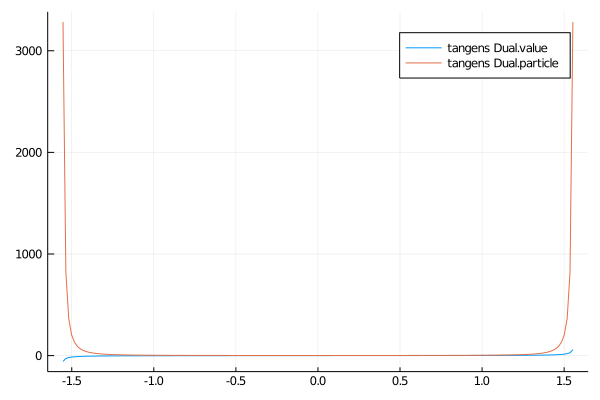

In [60]:
range =  collect(-π/2+π/180:π/180:π/2- π/180)
tang = forwardDerivate(tan, range)

plot(range, (x->x.v).(tang), label = "tangens Dual.value")
plot!(range, (x->x.dv).(tang), label = "tangens Dual.particle")

## Exact value - comparation 

In [63]:
x= symbols("x", real=true) # also integer, positive, negative...
f = tan(x);
dTan = diff(f,x);
dTan = convert(Function, dTan);

exactValue = dTan.(range);
myValue = (p->p.dv).(tang);

isTheSameValues(myValue, exactValue);


Wyniki są takie same


# Rosenbrock

## My value

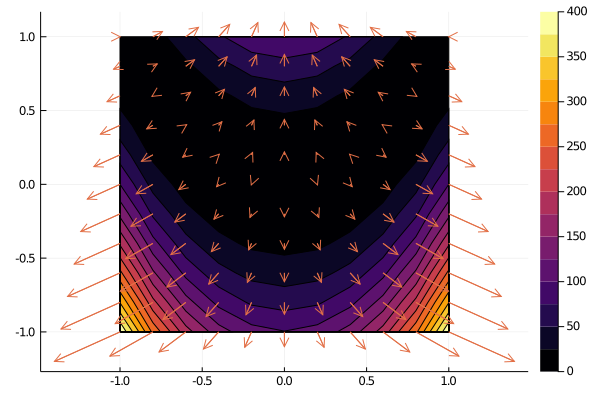

In [99]:
rosenbrock(x, y) = (1.0 - x*x) + 100.0*(y - x*x)*(y - x*x);
v = -1:.2:+1
n = length(v)
xv = repeat(v, inner=n)
yv = repeat(v, outer=n)

dx,dy,zv = forwardDerivate(rosenbrock, xv, yv);

zv = reshape(zv, n, n)
contour(v, v, zv, fill=true)
quiver!(xv[:], yv[:], gradient=(dx, dy))

In [104]:
gradient=(dx, dy)

([-0.399, -0.359, -0.319, -0.279, -0.23900000000000002, -0.199, -0.159, -0.11900000000000001, -0.079, -0.03899999999999999  …  0.359, 0.319, 0.279, 0.23900000000000002, 0.199, 0.159, 0.11900000000000001, 0.079, 0.03899999999999999, -0.001], [-0.2, -0.18, -0.16, -0.14, -0.12, -0.1, -0.08, -0.06, -0.04, -0.019999999999999997  …  -0.18, -0.16, -0.14, -0.12, -0.1, -0.08, -0.06, -0.04, -0.019999999999999997, 0.0])

In [ ]:
@benchmark forwardDerivate(rosenbrock, xv, yv)

## Exact value - comparation 

In [100]:
rosenbrock(x, y) = (1.0 - x*x) + 100.0*(y - x*x)*(y - x*x);
v = -1:.2:+1;
n = length(v);
xv = repeat(v, inner=n);
yv = repeat(v, outer=n);|

x,y = symbols("x, y", real=true) # also integer, positive, negative...

f = rosenbrock(x,y)
dxRosenbrock = diff(f,x);
dxRosenbrock = convert(Function, dxRosenbrock);
dyRosenbrock = diff(f,y);
dyRosenbrock = convert(Function, dyRosenbrock);

dxExactValue = 5e-4 *dxRosenbrock.(xv, yv);
dyExactValue = 5e-4 *dyRosenbrock.(xv, yv);

println("Porównanie dx: ");
isTheSameValues(dx, dxExactValue);
dxError = errorValue(dxExactValue, dx);
println();

println("Porównanie dy: ");
isTheSameValues(dy, dyExactValue);
dyError = errorValue(dyExactValue, dy);

println();
println("Średnia wartość błędu ");
mean([dxError, dyError])

#zv = reshape(zv, n, n)
#contour(v, v, zv, fill=true)
#quiver!(xv[:], yv[:], gradient=(dxExactValue, dyExactValue))

Porównanie dx: 
Wyniki są różne
Wartość błędu wynosi: 
-4.537974683544303

Porównanie dy: 
Wyniki są różne
Wartość błędu wynosi: 
-8.386886226830019e-17

Średnia wartość błędu 


-2.2689873417721516

# Jacobi matrix

## Test data

In [21]:
x= [i for i in -1.0:0.25:1.25];
range = [i for i in 0:π/360:2*π] ;
rangeTan = [i for i in -π/2+π/180:π/180:π/2- π/180];

## Jacobi - ReLU

## My values

In [31]:
ReLu(x) = x > zero(x) ? x : zero(x);

In [32]:
y = J(ReLu,x);

In [ ]:
@benchmark J(ReLu,x)

In [28]:
x= [i for i in -1.0:0.5:1];
display("Jacobi Relu")
y = jacobian(ReLu,x);
display(y)

"Jacobi Relu"

5×5 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  1.0

## Exact values 

In [29]:
ReLuLibJacobian()

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0])

## Jacobi - SoftMax

In [ ]:
y = J(softmax,x)

In [ ]:
@benchmark J(softmax,x)

## Jacobi - Sin

In [55]:
y = J(x -> sin.(x), range);

In [ ]:
@benchmark J(x -> sin.(x), range)

## Jacobi - Cos

In [ ]:
y = J(x -> cos.(x), range);

In [ ]:
@benchmark J(x -> cos.(x), range)

## Jacobi - Tan

In [ ]:
y = J(x -> tan.(x), rangeTan);

In [ ]:
@benchmark J(x -> tan.(x), range)